### 进化算法

In [ ]:
import numpy as np
import random
import math
import pandas as pd
from random import choice
import matplotlib.pyplot as plt


In [19]:

data = pd.read_csv(
    './data_1.csv', header=0,names=['n(r/min)', 'f(mm/r)', 'ap(mm)', 'MRR(mm3/s)', 'P(W)'])
data_normalized = data.apply(lambda x: (x - np.mean(x)) / (np.std(x)))
data_mean = data.mean()
data_std = data.std()
data_dfmax = data_normalized.max()
data_dfmin = data_normalized.min()


In [24]:
data_max = list(data_dfmax)
data_min = list(data_dfmin)
x_max = data_max[:-1] 
x_min = data_min[:-1]


In [36]:
data_std

n(r/min)      573.944043
f(mm/r)        40.583972
ap(mm)          0.597614
MRR(mm3/s)      2.535463
P(W)            0.128973
dtype: float64

In [ ]:
import torch.nn as nn
class Pw_Model(nn.Module):
    def __init__(self, input_dim):
        super(Pw_Model, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 2048),
            nn.ReLU(),
            # nn.Linear(2048,256),
            # nn.ReLU(),
            nn.Linear(2048, 1)
        )

    def forward(self, x):
        x = self.layers(x)
        x = x.squeeze(1)  # (B, 1) -> (B)
        return x


In [ ]:
import torch
model  = torch.load('all_save.pt')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)



In [32]:
#测试模型导入是否成功 与第一行数据比较
x_input = torch.Tensor([[-1.414214, -1.0, 1.212678, 1.371989]]).to(device)
output = model(x_input)
output = output.cpu().detach().numpy()
output[0]


-0.92124534

gen|  eval  |    f_opt    |    f_max    |    f_avg    |    f_min    |    f_std    
----------------------------------------------------------------------------------
 0 |   20   |  -1.4696493 |  -1.4696493 |  -1.4696496 |  -1.4696493 |2.3841858e-07
 1 |   40   |  -1.4696493 |  -1.4696493 |  -1.4696496 |  -1.4696493 |2.3841858e-07
 2 |   60   |  -1.4696493 |  -1.4696493 |  -1.4696496 |  -1.4696493 |2.3841858e-07
 3 |   80   |  -1.4696493 |  -1.4696493 |  -1.4696496 |  -1.4696493 |2.3841858e-07
 4 |  100   |  -1.4696493 |  -1.4696493 |  -1.4696496 |  -1.4696493 |2.3841858e-07
 5 |  120   |  -1.4696493 |  -1.4696493 |  -1.4696496 |  -1.4696493 |2.3841858e-07
 6 |  140   |  -1.4696493 |  -1.4696493 |  -1.4696496 |  -1.4696493 |2.3841858e-07
 7 |  160   |  -1.4696493 |  -1.4696493 |  -1.4696496 |  -1.4696493 |2.3841858e-07
 8 |  180   |  -1.4696493 |  -1.4696493 |  -1.4696496 |  -1.4696493 |2.3841858e-07
 9 |  200   |  -1.4696493 |  -1.4696493 |  -1.4696496 |  -1.4696493 |2.3841858e-07
 10|

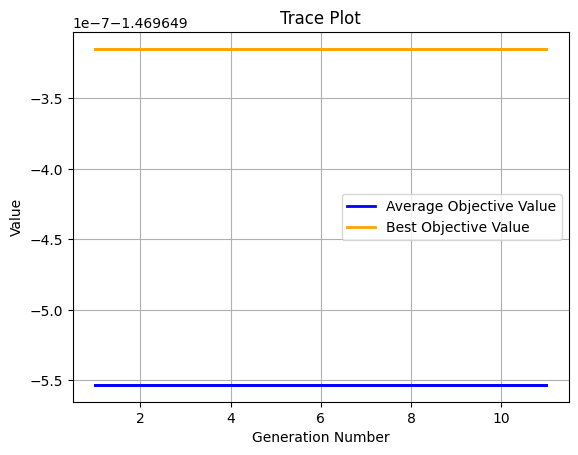

Execution time: 0.27207231521606445 s
Evaluation number: 220
The best objective value is: -1.4696493
The best variables are: 
-1.414213562373095	-1.5	-1.3339459376998315	-1.028991510855053	


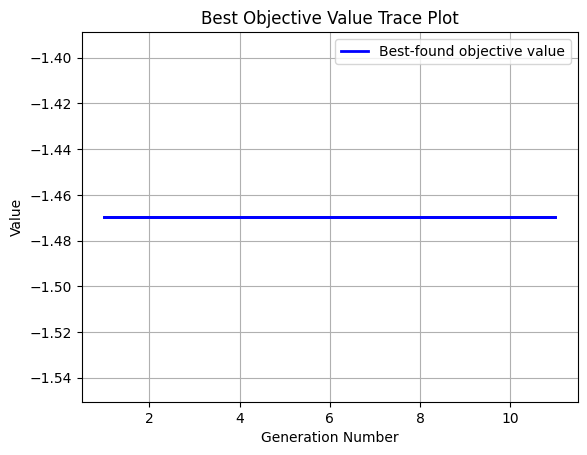

In [37]:
import geatpy as ea
import numpy as np

# 构建问题
r = 1  # 目标函数需要用到的额外数据


@ea.Problem.single
def evalVars(Vars):  # 定义目标函数（含约束）
    x_input = torch.Tensor([Vars]).to(device)
    f = model(x_input).cpu().detach().numpy()[0]  # 计算目标函数值
    CV = np.array(0,)  # 计算违反约束程度
    return f, CV


problem = ea.Problem(name='soea quick start demo',
                    M=1,  # 目标维数
                    maxormins=[1],  # 目标最小最大化标记列表，1：最小化该目标；-1：最大化该目标
                    Dim=4,  # 决策变量维数
                    varTypes=[0, 0, 0, 0],  # 决策变量的类型列表，0：实数；1：整数
                    lb=x_min,  # 决策变量下界
                    ub=x_min,  # 决策变量上界
                    evalVars=evalVars)
# 构建算法
algorithm = ea.soea_SEGA_templet(problem,
                                ea.Population(Encoding='RI', NIND=20),
                                MAXGEN=50,  # 最大进化代数。
                                logTras=1,  # 表示每隔多少代记录一次日志信息，0表示不记录。
                                trappedValue=1e-6,  # 单目标优化陷入停滞的判断阈值。
                                maxTrappedCount=10)  # 进化停滞计数器最大上限值。
# 求解
res = ea.optimize(algorithm, seed=1, verbose=True,
                drawing=1, outputMsg=True, drawLog=True)


In [44]:
best_pn = np.array([-1.414213562373095, -1.5, -
                    1.3339459376998315, -1.028991510855053, -1.4696493])
best_p = best_pn * data_std + data_mean
best_p


n(r/min)      488.320550
f(mm/r)       119.124041
ap(mm)          0.488529
MRR(mm3/s)      2.962459
P(W)            0.857313
dtype: float64